# Imports

In [88]:
#manipulação de dados
import pandas  as pd
import numpy   as np
import inflection
import regex   as re
import s3fs
import pickle

#visualização
import seaborn as sns
from matplotlib           import pyplot  as plt
from plotly               import express as px
from IPython.core.display import HTML
from pandas_profiling      import ProfileReport

#métricas
from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer
from sklearn              import metrics as m
from sklearn                 import manifold as mn

#processamento de dados
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#modelos
from sklearn              import cluster as c
from sklearn import  mixture as mx
from scipy.cluster import hierarchy as hr
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor 

# estudo de espaço
import umap.umap_ as umap
from sklearn import decomposition as  dcp
from sklearn.manifold import TSNE

## Helper funtions

In [89]:
from IPython.core.display    import HTML
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# load data

In [90]:
df_raw = pd.read_csv('C:/Users/Lavin/Documents/Comunidade DS/insiders clustering/data/raw/Ecommerce.csv',encoding= 'unicode_escape')

In [91]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [92]:
df1 = df_raw.copy()

**data dimensions**

In [93]:
df1.shape

(541909, 9)

**Rename columns**

In [94]:
old_cols = df1.columns
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase,old_cols))
df1.columns = new_cols

In [95]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country', 'unnamed: 8'],
      dtype='object')

**delete column**

In [96]:
df1.drop(columns='unnamed: 8',inplace=True)

In [97]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## Data types

In [98]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Checking NA

In [99]:
df1.isnull().sum()/len(df_raw)*100

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

### replace NA

In [100]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [101]:
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]
df_not_missing

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France


In [102]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000,19000+len(df_backup),1)

#merge original with reference
df1 = pd.merge(df1,df_backup,on='invoice_no',how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x','customer_id_y'])

In [103]:
df1.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [104]:
df_backup.head()

,invoice_no,customer_id
622,536414,19000
1443,536544,19001
1970,536545,19002
1971,536546,19003
1972,536547,19004


In [105]:
1- df1.shape[0]/df_raw.shape[0]

0.0

In [106]:
df1.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Changing types

In [107]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

In [108]:
#df1['invoice_no'].astype(int)

In [109]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id            float64
dtype: object

'Invoice_no' possui letras em algumas linhas, necessita de limpeza mais detalhada

# Data description

In [110]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850.0


'invoice_no', : categorical atributtes

'stock_code': categorical atributtes

'description': categorical atributtes

'quantity': numerical atributtes

'invoice_date': numerical atributtes

'unit_price': numerical atributtes

'customer_id': categorical atributtes

'country': categorical atributtes

Remover 'European Community' e 'Unspecified'

# Filter

In [111]:
df2 = df1.copy()

In [112]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.040,:]

#stock code != ['POST','D','M','DOT','CRUK','C2']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK','C2'])]

# description
df2.drop(columns='description',inplace=True)

# country
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]


df2 = df2[~df2['customer_id'].isin([16446])]


# description
## quantity - Negative numbers means product returns
df_returns = df2.loc[df2['quantity']<0,:]
df_purchase = df2.loc[df2['quantity']>0,:]

# Features enginering

In [113]:
df3 = df2.copy()

In [114]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850.0


## Feature creation

In [115]:
df_ref = pd.DataFrame(df3['customer_id'])

In [116]:
df_ref =  df_ref.drop_duplicates(ignore_index=True)

### Receita bruta

**Gross Revenue**

In [117]:
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:,'quantity'] * df_purchase.loc[:,'unit_price']
df_monetary = df_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref,df_monetary,on='customer_id',how='left')

C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Rencencia - dias da ultima compra

In [118]:
df_recency = df_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()- df_recency['invoice_date']).dt.days
df_recency = df_recency.drop(columns = 'invoice_date')
df_ref = pd.merge(df_ref,df_recency,on='customer_id',how='left')

### Quantidade de produtos comprados

In [119]:
df_prod_quant = (df_purchase[['customer_id','stock_code']].groupby('customer_id')
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns = {'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref,df_prod_quant,on='customer_id',how='left')

### Frequência

**Frequência**

In [120]:
df_aux = (df3[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .agg(max_ = ('invoice_date','max'),
                                                               min_ = ('invoice_date','min'),
                                                               days_ = ('invoice_date',lambda x:(x.max()-x.min()).days+1),
                                                               buy_  = ('invoice_date','count'))
                                                          .reset_index())
                                                          

df_aux['freq'] = df_aux.apply(lambda x: x['buy_']/x['days_'] if x['days_'] !=0 else 0,axis=1)
df_ref = pd.merge(df_ref,df_aux[['customer_id','freq']],on='customer_id',how='left')

### Devoluções

**Returns**

In [121]:
df_avg_returns = df_returns[['customer_id','quantity']].drop_duplicates().groupby('customer_id').sum().abs().reset_index().rename(columns={'quantity':'qtde_returns'})
df_ref = pd.merge(df_ref,df_avg_returns,on='customer_id',how='left')
df_ref.loc[df_ref['qtde_returns'].isna(),'qtde_returns'] = 0

In [122]:
df_ref = df_ref.dropna()

In [123]:
df4 = df_ref.copy()

In [124]:
df4.shape

(5695, 6)

# EDA

In [125]:
df5 = df4.copy()

In [126]:
df_aux = df5.drop(columns='customer_id')

## Estudo do Espaço

In [127]:
#cols_select = ['gross_revenue', 'recency_days', 'qtde_products', 'freq', 'qtde_returns']

In [128]:
#df_aux = df_aux[cols_select]

In [129]:
df_aux.head()

,gross_revenue,recency_days,qtde_products,freq,qtde_returns
0,5391.21,372.0,297.0,0.486111,21.0
1,3232.59,56.0,171.0,0.048780,6.0
2,6705.38,2.0,232.0,0.045699,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.136364,22.0


In [130]:
mm = MinMaxScaler()

df_aux['gross_revenue'] = mm.fit_transform(df_aux[['gross_revenue']])
df_aux['recency_days'] = mm.fit_transform(df_aux[['recency_days']])
df_aux['qtde_products'] = mm.fit_transform(df_aux[['qtde_products']])
df_aux['freq'] = mm.fit_transform(df_aux[['freq']])
df_aux['qtde_returns'] = mm.fit_transform(df_aux[['qtde_returns']])

In [131]:
X = df_aux.copy()

## PCA

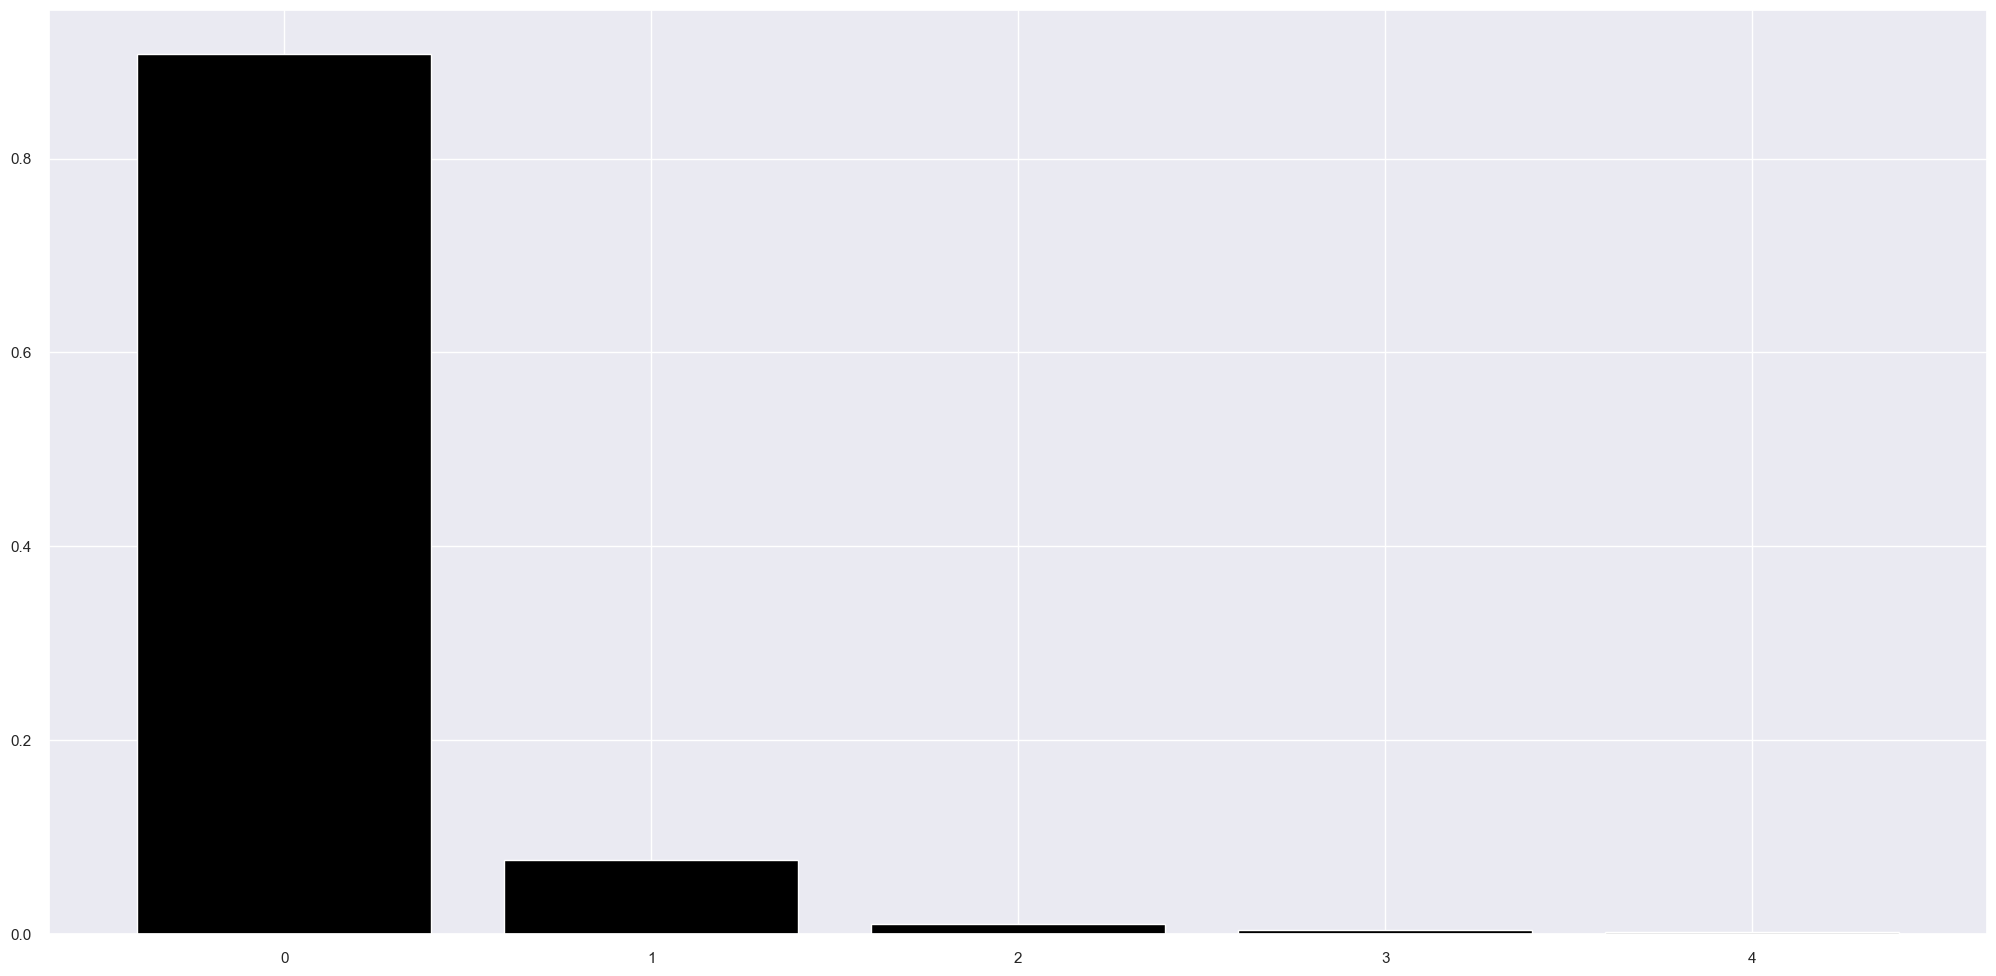

In [132]:
pca = dcp.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

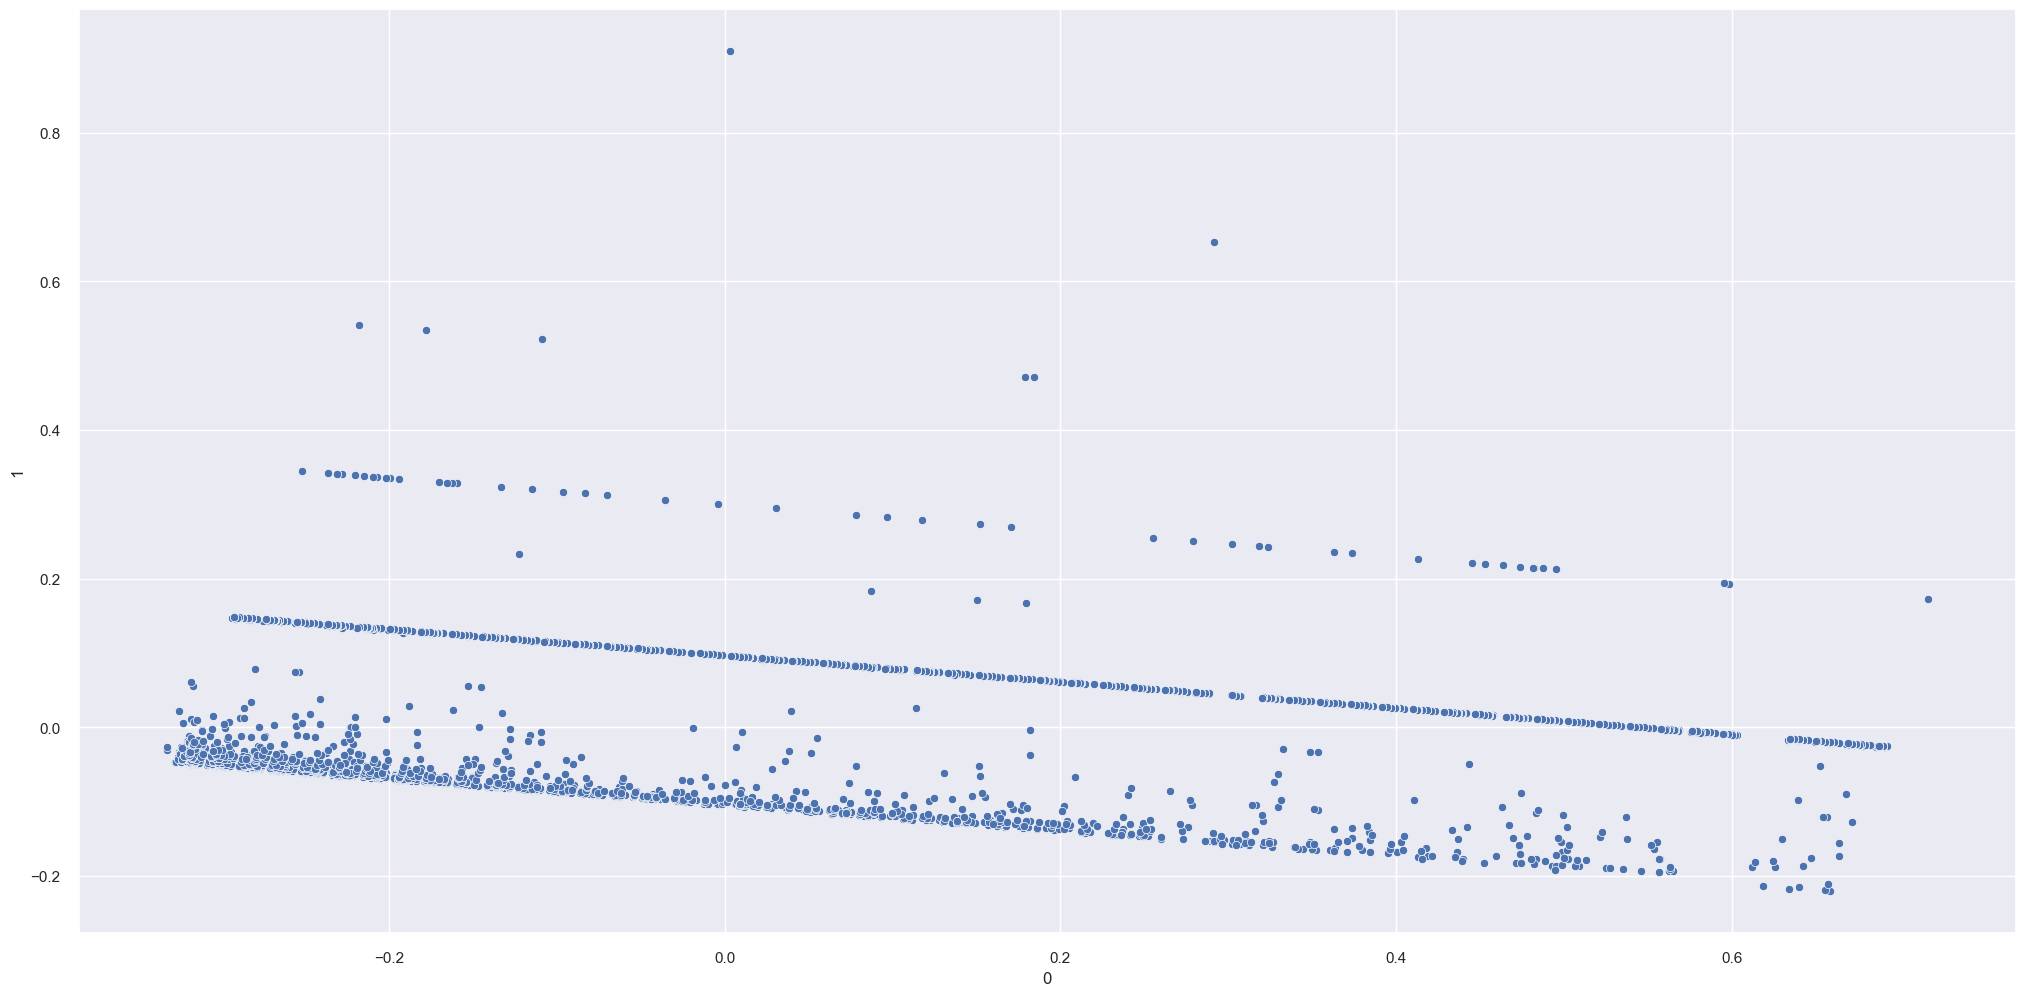

In [133]:
sns.scatterplot( x=0, y=1, data=df_pca );

## UMAP

In [134]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

KeyboardInterrupt: 

## T-SNE

In [ ]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

### Tree-based embedding

In [ ]:
X = df_aux.drop(columns=['gross_revenue'],axis=1)
y = df_aux['gross_revenue']


# model definition
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)

#model training
rf_model.fit(X,y.values)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))
#dataframe Leaf

In [ ]:
df_leaf.head()

In [ ]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)


#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_tree);

# Data preparation

Distribuição normal e não possui outlier - stardart scaler

distribuição normal e possui outilier - robust scaler

não distribuição normal - Min max Scaler


**Teste de normalidade**

**QQ plot** - Quantile Quantile Plot ( Quatile teorica x Quatile real)

**KS Teste** - Kolgomorov Smirnoff ( Teste de Hipótese ) se P-valor > 0.5 Distribuição normal, P-valor < 0.5 - Não distribuição normal

In [ ]:
# df6 = df5.copy()

In [ ]:
# df6.head()

In [ ]:
# mm = MinMaxScaler()

# df6['gross_revenue'] = mm.fit_transform(df6[['gross_revenue']])
# df6['recency_days'] = mm.fit_transform(df6[['recency_days']])
# df6['qtde_invoice'] = mm.fit_transform(df6[['qtde_invoice']])
# df6['qtde_items'] = mm.fit_transform(df6[['qtde_items']])
# df6['qtde_products'] = mm.fit_transform(df6[['qtde_products']])
# df6['avg_basket_size'] = mm.fit_transform(df6[['avg_basket_size']])
# df6['avg_unique_basket_size'] = mm.fit_transform(df6[['avg_unique_basket_size']])
# df6['freq'] = mm.fit_transform(df6[['freq']])
# df6['avg_rec_days'] = mm.fit_transform(df6[['avg_rec_days']])
# df6['qtde_returns'] = mm.fit_transform(df6[['qtde_returns']])
# df6['avg_ticket'] = mm.fit_transform(df6[['avg_ticket']])


In [ ]:
# df6.head()

# Feature selection

In [ ]:
# df7 = df6.copy()

In [ ]:
#cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'freq', 'qtde_returns']

In [ ]:
#df7 = df7[cols_select]

# Fine tunning

In [ ]:
#X = df7.drop(columns='customer_id')
X = df_tree

In [ ]:
X.head()

In [ ]:
clusters = np.arange(2,31,1)

## KNN

In [ ]:
sil_k = []
for k in clusters:
    # model definition
    k_model = c.KMeans(n_clusters=k)

    #model training
    k_model.fit(X)

    #model predict
    labels = k_model.predict(X)

    #model performace
    sil_k.append(m.silhouette_score(X,labels,metric='euclidean'))

## GMM

In [ ]:
gmm_k = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_k.append(m.silhouette_score(X,labels,metric='euclidean'))

## H-clustering

In [ ]:
hr_model = hr.linkage( X, 'ward' )

In [ ]:
hc_k = []
for k in clusters:
    # model definition
    hc_model = hr.linkage(X,'ward')

    #model predict
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace
    hc_k.append(m.silhouette_score(X,labels,metric='euclidean'))

## DBSCAN

In [ ]:
eps=0.2
min_samples = 20
#model training e predict
dbscan_model = c.DBSCAN(eps=eps,min_samples=min_samples)

#model training e predict
labels = dbscan_model.fit_predict(X)

db_k_tree = m.silhouette_score(X,labels,metric='euclidean')

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nei = NearestNeighbors(n_neighbors=min_samples).fit(X)
dist, indi = nei.kneighbors(X)

## results tree

In [ ]:
df_results_tree = pd.DataFrame({
    'Kmeans': sil_k,
    'GMM': gmm_k,
    'HC': hc_k,
}).T
df_results_tree.columns = clusters
df_results_tree.style.highlight_max(color='lightgreen',axis=1)

In [ ]:
db_k_tree

In [ ]:
#df_tree.to_csv('C:/Users/Lavin/Documents/Comunidade DS/insiders clustering/src/data/df_tree_embedding.csv',index=False)

# Model training

## Final model

In [ ]:
k = 8

In [ ]:
X = df_tree

In [ ]:
gmm_model = mx.GaussianMixture(n_components=k,random_state=32)

gmm_model.fit(X)

labels = gmm_model.predict(X)

In [ ]:
print('SS value',m.silhouette_score(X,labels,metric='euclidean'))

In [ ]:
# visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
# visualizer.fit(X)
# visualizer.finalize()

### Cluster analysis

In [ ]:
df9 = df5.copy()
df9['clusters'] = labels

# Cluster profile

In [ ]:
df9.head()

In [ ]:
# number of customers
df_cluster = df9[['customer_id','clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100
# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue,how='inner',on='clusters')

# avg recency days
df_avg_recency_days =  df9[['recency_days','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days,how='inner',on='clusters')

# avg invoice no
df_avg_invoice_no =  df9[['qtde_products','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invoice_no,how='inner',on='clusters')

df_ticket =  df9[['freq','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_ticket,how='inner',on='clusters')

df_ticket =  df9[['qtde_returns','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_ticket,how='inner',on='clusters')

In [ ]:
df_cluster.sort_values(by='gross_revenue',ascending=False)

6 - Cluster Insiders

5 - Cluster More products

0 - Cluster Spend Money

3 - Cluster Even More products

7 - Cluster Less days

2 - Cluster Less 1k

1 - Cluster Stop Returns

4 - Cluster More buy

# EDA II

In [ ]:
df10 = df9.copy()
df10['clusters'] = df9['clusters']

In [ ]:
df10.head()

# Deploy

In [ ]:
import sqlite3
from sqlalchemy import create_engine

In [ ]:
df10['customer_id'] = df10['customer_id'].astype(int)
df10['recency_days'] = df10['recency_days'].astype(int)
df10['qtde_products'] = df10['qtde_products'].astype(int)
df10['qtde_returns'] = df10['qtde_returns'].astype(int)

In [ ]:
df10.dtypes

## SQLITE

In [ ]:
#Create table

# query_create_table_insiders = """
#     CREATE TABLE INSIDERS (
#         customer_id      INTEGER,
#         gross_revenue    REAL,
#         recency_days     INTEGER,
#         qtde_products    INTEGER,
#         freq             REAL,
#         qtde_returns     INTEGER,
#         clusters         INTEGER
#     )
# """

# conn = sqlite3.connect('insiders_db.sqlite')
# conn.execute(query_create_table_insiders)
# conn.commit()
# conn.close()

# #insert data
# conn = create_engine('sqlite:///insiders_db.sqlite')
# df10.to_sql('insiders',con=conn,if_exists='append',index=False)


In [ ]:
#consulting database
# query = """
#     SELECT *
#     FROM insiders
# """

# df = pd.read_sql_query(query,conn)

In [ ]:
# df.head()